# Dynamic Pricing Neural Network Model Training

The purpose of this notebook is to demonstrate how to train a TensorFlow neural network model for predicting an optimal price based on e-commerce events stored in a MongoDB Atlas feature store.

Our ecommerce store has the following data model for capturing user behavior events:

| Field         | Data Type | Description                                               | Example Values           |
|---------------|-----------|-----------------------------------------------------------|--------------------------|
| product_name  | String    | The name of the product                                   | "MongoDB Notebook"       |
| product_id    | Integer   | Unique identifier for the product                         | 98803                    |
| action        | String    | Type of action performed on the product (user interaction)| "view", "add_to_cart", "purchase" |
| price         | Float     | Price of the product                                      | 18.99                    |
| timestamp     | String    | ISO format timestamp of when the event occurred           | "2024-03-25T12:36:25.428461" |
| encoded_name  | Integer   | An encoded version of the product name for machine learning models | 23363195            |

This table assumes the product["price"] field is a float representing the price of the product in a single currency (e.g., USD). The encoded_name field is considered an integer, which could represent a hash or an encoding used to transform the product name into a numerical format suitable for machine learning models. The timestamp field is a string formatted as an ISO timestamp, which provides the exact date and time when the action was recorded. The example values are placeholders and should be replaced with actual data from your application.
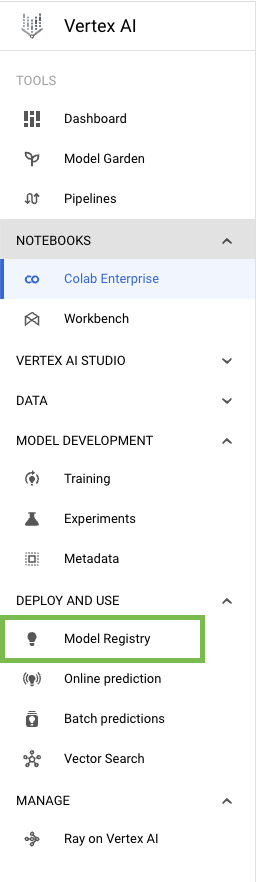


## Connecting to the MongoDB Database

First, we need to install the necessary Python packages and establish a connection to our MongoDB database.

In [ ]:
```python
!pip install pymongo
!pip install 'pymongo[srv]'
!pip install pandas
from pymongo import MongoClient
import pandas as pd
import keras

In [ ]:
# Replace the below connection string with your MongoDB connection URI
conn_string = "your_mongodb_connection_string_here"
client = MongoClient(conn_string)

In [ ]:
# Specify the database and collection
db = client["your_database_name"]
collection = db["your_collection_name"]

## Data Cleaning

Once connected, we'll fetch the data and perform some basic cleaning operations to prepare it for model training.

In [ ]:
# Get all the documents
documents = collection.find()

# Convert the documents into a list and then into a DataFrame
df = pd.DataFrame(list(documents))

# Drop unnecessary columns
df = df.drop(columns=['product_name', 'product_id', 'timestamp', 'tensor'])

# Extracting the 'amount' from the 'price' column and converting it to float
df['price'] = df['price'].apply(lambda x: float(x['amount']) if isinstance(x, dict) and 'amount' in x else None)

df = df.dropna()

## Building the Dynamic Pricing Model

Next, we import the necessary TensorFlow and scikit-learn libraries, encode categorical variables, and normalize our data.

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [ ]:
# Encode categorical variables
label_encoders = {}
for column in ['action', 'encoded_name']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

df.head()

In [ ]:
# Standardizing
scaler = StandardScaler()
df[['action', 'encoded_name']] = scaler.fit_transform(df[['action', 'encoded_name']])

df.head()

## Saving the Encoder for Event Data Pre-processing

We'll save the encoder objects to Google Cloud Storage for later use in preprocessing new data for predictions. This code will generate joblib files to save the encoding and standardizing criteria from the above preprocessing and upcoming training.

In [ ]:
!pip install google-cloud-storage
from google.cloud import storage
import joblib
import io

In [ ]:
# Initialize a client
storage_client = storage.Client()

# The name of your GCP bucket
bucket_name = 'dyn_pricing_scaler'

# The path within your bucket to save the scaler object
destination_blob_name = 'labelEncoder.joblib'

# Create a buffer
buffer = io.BytesIO()

# Dump the scaler object to the buffer
joblib.dump(label_encoders, buffer)

# Now upload the buffer content to GCS
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)

# Rewind the buffer's file pointer to the beginning of the file
buffer.seek(0)

# Upload the contents of the buffer
blob.upload_from_file(buffer, content_type='application/octet-stream')

print(f"Uploaded scaler to gs://{bucket_name}/{destination_blob_name}")

In [ ]:
# Initialize a client
storage_client = storage.Client()

# The name of your GCP bucket
bucket_name = 'dyn_pricing_scaler'

# The path within your bucket to save the scaler object
destination_blob_name = 'scaler.joblib'

# Create a buffer
buffer = io.BytesIO()

# Dump the scaler object to the buffer
joblib.dump(scaler, buffer)

# Now upload the buffer content to GCS
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)

# Rewind the buffer's file pointer to the beginning of the file
buffer.seek(0)

# Upload the contents of the buffer
blob.upload_from_file(buffer, content_type='application/octet-stream')

print(f"Uploaded scaler to gs://{bucket_name}/{destination_blob_name}")

## Training the Model

With our data prepared, we'll split it into training and testing sets, define our neural network architecture, and train our model. Please remind this is a model meant for a simple demo.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Splitting data into training and testing sets
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print the model summary to check the architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,  # Further split the training set for validation
                    epochs=10,  # Number of epochs to train for
                    verbose=1,  # Show training output
                    )

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

## Test Prediction

After training, we make a test prediction to verify the model's performance.

In [ ]:
import numpy as np

# Example new data point converted into a tensor
new_data = np.array([[1.225999, -0.957973]])

predicted_price = model.predict(new_data)
print("Predicted Price:", predicted_price[0])

## Saving the Model

Finally, we'll save our trained model to Google Cloud Storage.

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'your-gcp-project-id'
!gcloud config set project {project_id}

model_dir = 'your-model-directory'

# Save the model to GCS
model_dir = f'gs://{bucket_name}/{model_dir}
model.save(model_dir)

bucket_name = 'your-cloud-storage-bucket-name'
model_dir = 'your-model-directory'
model_path = 'your-model-path'
!gsutil mb -l us-central1 gs://{bucket_name}  # Create the bucket if necessary
!gsutil cp -r {model_dir} gs://{bucket_name}/{model_path}

Next we'll register our trained model in the VertexAI model registry.

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project='your-gcp-project-id', location='your-gcp-region')

#Model registry

model_display_name = 'dyn_pricingv1'
model_description = 'TensorFlow dynamic pricing model'
bucket_name = 'your-gcp-bucket-name'
model_path = 'your-model-path'

model = aiplatform.Model.upload(
    display_name=model_display_name,
    artifact_uri=f'gs://{bucket_name}/{model_path}',
    serving_container_image_uri='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest',
    description=model_description,
)

After this you should be able to see your model in the VertexAI model registry GUI. You can follow [this guide](https://cloud.google.com/vertex-ai/docs/general/deployment) to deploy the model to a live endpoint.

